# Based on David Rawlinson's work

Demo of DoWhy for PyCon Australia talk:

https://youtu.be/ilpSZiDjdv0?si=AZMlK6JWxULD_jfW

https://github.com/drawlinson/pyconau-dowhy-demo/blob/main/PyconDoWhyDemo.ipynb

In [1]:
import dowhy
import pandas as pd
import numpy as np

In [2]:
from IPython.display import Image, display
from io import StringIO, BytesIO   
import pydot
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Dataset

#### NSW Experimental Group – Individuals randomly assigned to a job training program in the 1970s.

This is also the time to do any preprocessing of the data, and / or create variables derived from columns (e.g. mapping categorical data encoded as numbers to indicator variables).

In [4]:
url = 'https://raw.githubusercontent.com/drawlinson/pyconau-dowhy-demo/refs/heads/main/lalonde.csv'
dataset = pd.read_csv(url)
dataset.head(5)

,ID,Training,Age,Education_years,Married,No_Degree,Wage_1974,Wage_1975,Wage_1978
0,0,False,23,10,0,1,0.0,0.0,0.00
1,1,False,26,12,0,0,0.0,0.0,12383.68
2,2,False,22,9,0,1,0.0,0.0,0.00
3,3,False,18,9,0,1,0.0,0.0,10740.08
4,4,False,45,11,0,1,0.0,0.0,11796.47


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               445 non-null    int64  
 1   Training         445 non-null    bool   
 2   Age              445 non-null    int64  
 3   Education_years  445 non-null    int64  
 4   Married          445 non-null    int64  
 5   No_Degree        445 non-null    int64  
 6   Wage_1974        445 non-null    float64
 7   Wage_1975        445 non-null    float64
 8   Wage_1978        445 non-null    float64
dtypes: bool(1), float64(3), int64(5)
memory usage: 28.4 KB


# Causal Model structure
In Causal Inference, we rely on prior knowledge of causal model structure. This can be provided in various forms, 
but in DoWhy, we must define a **DAG** (Directed Acyclic Graph). 
A **Graph** is a network of **Nodes** (aka vertices) and **Edges** between them.
**Directed** means each edge has a direction, from the cause, to the effect. 
**Acyclic** means the graph must not have cycles (loops). 
In this case, the Nodes are the columns in the data file, and are also known as **Variables**. 
We must define the edges here as a string; if your graph is complex you can use the graphical editor [CausalWizard.app](https://CausalWizard.app). 

In [6]:
g = """digraph {

Training;
No_Degree;
Age;
Education_years;
Married;
Wage_1974;
Wage_1978;

Training -> Wage_1978;

Wage_1974 -> Training;
No_Degree -> Training;
Education_years -> Training;
Married -> Training;

Wage_1974 -> Wage_1978;
No_Degree -> Wage_1978;
Education_years -> Wage_1978;
Married -> Wage_1978;

Age -> Wage_1978;

}"""

# DoWhy Step 1/4: Create Causal Model

In [7]:
from dowhy import CausalModel                        
from IPython.display import Image, display          
import pydot                                        
from io import BytesIO 

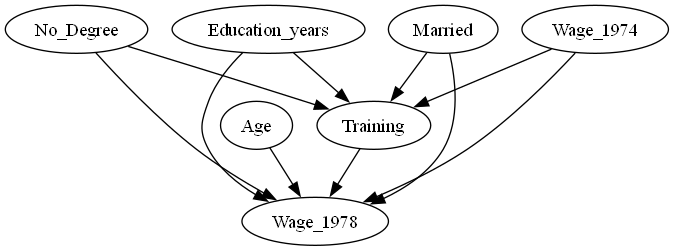

In [8]:
# Define treatment and outcome
treatment_col = 'Training'                           # Treatment variable
outcome_col = 'Wage_1978'                            # Outcome variable

# Create causal model WITHOUT the graph
model = CausalModel(                                 # Create a causal model instance
    data=dataset,                                    # Use the dataset (DataFrame) as input
    treatment=treatment_col,                         # Set the treatment column
    outcome=outcome_col,                             # Set the outcome column
    graph=None                                       # <-- Don't pass graph here
)

# Manually assign the graph later using a safe method
model._graph_dot = g                                 # Save DOT graph string
model._graph = None                                  # Bypass internal graph object

# Display the DOT graph with pydot manually
(graph,) = pydot.graph_from_dot_data(g)              # Parse DOT graph
png = graph.create_png()                             # Render to PNG
display(Image(data=png))                             # Show in Jupyter

# DoWhy Step 2/4: Identify effect

In [9]:
import networkx as nx                         # NetworkX for graph structure
from dowhy import CausalModel                 # DoWhy for causal inference

# Manually construct a causal DAG using networkx.DiGraph
nx_graph = nx.DiGraph()                       

# Add all the nodes
nx_graph.add_nodes_from([
    "Training", "No_Degree", "Age", "Education_years", "Married",
    "Wage_1974", "Wage_1978"
])

# Add all the edges according to the original DOT graph
nx_graph.add_edges_from([
    ("Training", "Wage_1978"),
    
    ("Wage_1974", "Training"),
    ("No_Degree", "Training"),
    ("Education_years", "Training"),
    ("Married", "Training"),

    ("Wage_1974", "Wage_1978"),
    ("No_Degree", "Wage_1978"),
    ("Education_years", "Wage_1978"),
    ("Married", "Wage_1978"),

    ("Age", "Wage_1978")
])

# Create the causal model directly from the networkx graph
model = CausalModel(
    data=dataset,                             # Your dataset (pandas DataFrame)
    treatment='Training',                     # Treatment variable
    outcome='Wage_1978',                      # Outcome variable
    graph=nx_graph                            # Pre-constructed graph
)

# Identify the estimand
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                               
───────────(E[Wage_1978|No_Degree,Education_years,Married,Wage_1974])
d[Training]                                                          
Estimand assumption 1, Unconfoundedness: If U→{Training} and U→Wage_1978 then P(Wage_1978|Training,No_Degree,Education_years,Married,Wage_1974,U) = P(Wage_1978|Training,No_Degree,Education_years,Married,Wage_1974)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



# DoWhy Step 3/4: Estimate effect

In [10]:
#method = "backdoor.propensity_score_weighting"
method = "backdoor.linear_regression"

desired_effect = "ate"     # Define the target population for the effect (ATE = Average Treatment Effect)

estimate = model.estimate_effect(                     # Estimate the causal effect using the identified estimand
    identified_estimand,                              # Use the previously identified estimand
    method_name=method,                               # Specify the estimation method (e.g., linear regression, propensity score)
    target_units=desired_effect,                      # Target effect for the average population
    method_params={"weighting_scheme":"ips_weight"}   # Additional method parameters (e.g., inverse probability weighting)
)
print("Causal Estimate is " + str(estimate.value))

Causal Estimate is 1629.4369006442412


*On average, completing the training course will cause participants to earn $1629 more, than not completing the training.* 

# DoWhy Step 4/4: Refute effect

How confident can we be that the effect is real?

In [11]:
refute_placebo_treatment = model.refute_estimate(    # Run placebo test to assess robustness
    identified_estimand,                             # Use the previously identified causal estimand
    estimate,                                        # Use the estimated causal effect
    method_name="placebo_treatment_refuter",         # Specify placebo refuter method
    placebo_type="permute"                           # Permute treatment values to simulate random placebo
)
print(refute_placebo_treatment)                      # Print the results of the placebo test

Refute: Use a Placebo Treatment
Estimated effect:1629.4369006442412
New effect:-71.71094108105484
p value:0.96



* Bootstrap stability and significance test given permuted outcomes

* Permute treatment refutation - does effect disappear?

* Add unobserved confounder - is effect stable?

# Counterfactual outcomes
This step is optional, but interesting. You are likely to want to know how to estimate counterfactual scenarios such as "what would have happened if I had applied the treatment to all the samples?". You can easily obtain these estimates from your model, using DoWhy.

Note: Not all estimators support the do() operator.

*What actually happened to the study group?*

In [12]:
treatment_value_treated = True                                        # Define the treated group value
treatment_value_control = False                                       # Define the control group value

dataset_copy = model._data.copy()                                     # Create a copy of the data to avoid modifying the original

mean_outcome = dataset_copy.loc[:, outcome_col].mean()                # Calculate the overall mean of the outcome
print(f'Actual mean outcome [all participants]: {mean_outcome}')      # Display overall outcome mean

# Define a helper function to get the mean outcome of a specific cohort
def get_cohort_outcome(
    df: pd.DataFrame,                                                 # Input DataFrame
    col_selector,                                                     # Column used to filter cohort
    cohort_value,                                                     # Value to identify cohort group
):
    cohort_rows = df[df[col_selector] == cohort_value]                # Filter rows that match the cohort value
    mean_outcome = cohort_rows.loc[:, outcome_col].mean()             # Compute mean outcome for the cohort
    return mean_outcome                                               # Return mean outcome

# Get mean outcome for control group
mean_outcome_control = get_cohort_outcome(
    dataset_copy,
    treatment_col,
    treatment_value_control,
)
print(f'Actual mean outcome [control group]: {mean_outcome_control}') # Display mean outcome for control

# Get mean outcome for treated group
mean_outcome_treated = get_cohort_outcome(
    dataset_copy,
    treatment_col,
    treatment_value_treated,
)
print(f'Actual mean outcome [treated group]: {mean_outcome_treated}') # Display mean outcome for treated

Actual mean outcome [all participants]: 5300.763698561798
Actual mean outcome [control group]: 4554.801126
Actual mean outcome [treated group]: 6349.143530270271


*The average outcome for all participants is \\$5,300. Those who received the training averaged \\$6,349, while those who did not receive the training averaged $4,554.*

#### DoWhy "do" operator allows interventions to be applied:

*What would have happened if all/none of the participants completed the training course?*

In [13]:
# "do(x): Given a value x for the treatment, returns the 
# expected value of the outcome when the treatment is 
# intervened to a value x."

cf_estimate_control = estimate.estimator.do(           # Perform the do-calculus operation to simulate intervention
    x=treatment_value_control,                         # Set the treatment variable to its control value
    data_df=dataset_copy,                              # Use a copy of the original dataset for counterfactual estimation
)
print(f'Mean outcome if all control [all participants]: {cf_estimate_control}')

cf_estimate_treated = estimate.estimator.do(           # Simulate the outcome under treatment using do-calculus
    x=treatment_value_treated,                         # Set the treatment variable to its treated value
    data_df=dataset_copy,                              # Use the copied dataset to estimate counterfactuals
)
print(f'Mean outcome if all treated [all participants]: {cf_estimate_treated}')

Mean outcome if all control [all participants]: 4605.521823503883
Mean outcome if all treated [all participants]: 6234.958724148124


*If none of participants received the training, the average outcome would be \\$4605. If all of participants received the training, the average outcome would be \\$6234.*